In [524]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from scipy.io import loadmat
from sklearn.metrics import classification_report, accuracy_score

import plotly.graph_objects as go

np.seterr(divide='ignore', invalid='ignore')
# from sklearnex import patch_sklearn
#
# patch_sklearn()
# sklearnex.get_config()


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [585]:
from glob import glob

S_sentinel_bands = glob("/tmp/shared/dataset_5/**/*B?*.tiff", recursive=True)
S_sentinel_bands.sort()
S_sentinel_bands

['/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B01_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B02_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B03_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B04_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B05_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B06_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B07_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B08_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B09_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A

In [586]:
def getCategory(path):
    url = path.split("/")
    category = url[4]
    return category


def getParentImageNumber(path):
    url = path.split("/")
    category = url[5]
    return category


def getImagePartNumber(path):
    url = path.split("/")
    category = url[6]
    return category

In [587]:
def toGrouped(array):
    np_array = np.asarray(array)
    print(f"Shape of array is {np_array.shape}")
    grouped_items = []
    for i in np_array:
        tpl = (i, getCategory(i), getParentImageNumber(i), getImagePartNumber(i))
        grouped_items.append(tpl)

    return np.asarray(grouped_items)

In [588]:
grouped_items = toGrouped(S_sentinel_bands)

Shape of array is (7242,)


In [589]:
categories_to_include = ["water", "forest", "field", "city"]

In [590]:
def getLearnCategories():
    dataset_map = {}
    for category in categories_to_include:
        items = grouped_items[grouped_items[:, 1] == category]
        dataset_map[category] = items
    return dataset_map

In [591]:
categories_to_learn = getLearnCategories()

In [592]:
def createCategoriesNumbersMap():
    numbers_map = {}
    for idx, category in enumerate(categories_to_learn):
        numbers_map[category] = idx+1
    return numbers_map

In [593]:
categories_map = createCategoriesNumbersMap()

In [594]:
from itertools import groupby

def prepareBeforeTraining():
    categories = {}
    for category_key, category_value in categories_to_learn.items():
        items = []
        image_part_items = groupby(category_value, key= lambda x: x[2])
        for key, group in image_part_items:
            grouped_parts = groupby(group, key=lambda x: x[3])
            for key1, group1 in grouped_parts:
                items.append(list(group1))
       # items = sorted(items)
        categories[category_key] = np.asarray(items)
    return categories

In [595]:
prepared_items = prepareBeforeTraining()

In [596]:
def loadImages():
    loaded_images = {}
    for category_key, category_value in prepared_items.items():
        ff = []
        for item in category_value:
            l = []

            if len(item) > 12:
                print(f"item {item[0][0]}")

            for file_path in item:
                with rio.open(file_path[0], 'r') as f:
                    img = f.read(1)
                    l.append(np.asarray(img))

            if len(l[0]) == len(l[1]) and len(l[0][0]) == len(l[1][0]):
                ff.append(np.asarray(l))
        loaded_images[category_key] = ff
    return loaded_images

In [597]:
loaded_images = loadImages()

In [598]:
import itertools

def createVectors():
    cat_vec = {}
    for cat_key, cat_val in loaded_images.items():
        print(f"Processing {cat_key}")
        itms = [[] for _ in range(12)]
        for img_group in cat_val:
            #grp = [[] for _ in range(12)]
            #print(f"Size of img group {len(img_group)}")
            for grp_idx,img in enumerate(img_group):
                #print(f"Index of type {grp_idx}. Array size: {len(grp)}")
                if len(img.shape) == 2:
                    vec = img.flatten()
                    itms[grp_idx].extend(vec)
            # if cat_key == "field":
            #         print(f"Size of itwm {len(itms[0])}")
        print(f"Size of {cat_key} is {len(itms[1])}")
        cat_vec[cat_key] = np.asarray(itms,  dtype=int)
    return cat_vec


In [599]:
vectors = createVectors()

Processing water
Size of water is 155000
Processing forest
Size of forest is 456100
Processing field
Size of field is 837600
Processing city
Size of city is 307500


In [600]:
def createYDatDict():
    y_dict = {}
    for val, num in categories_map.items():
        shape_length = vectors[val].shape[1]
        y_dict[val] = np.full(shape_length, num)
    return y_dict

In [601]:
y_data_cat = createYDatDict()

In [602]:
def flattenXY():
    x_dt = [[] for _ in range(12)]
    for item in vectors.values():
        for idx, item1 in enumerate(item):
            x_dt[idx].extend(item1)

    y_dt = []
    for item in y_data_cat.values():
        y_dt.extend(item)

    x_array = np.asarray(x_dt)
    x_array_changed = np.moveaxis(x_array, -1, 0)

    return (np.asarray(x_array_changed), np.asarray(y_dt))

In [603]:
x_data, y_data = flattenXY()

In [604]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled = scaler.fit_transform(x_data)

In [605]:
import random

def split_train_data2(x, y, coef):
    cnt = x.shape[0]
    items_to_train = int(cnt * coef)
    items_to_test = cnt - items_to_train
    percentile = int((1 - coef) * 100.0)
    print(f"Train size: {items_to_train}. Test size: {items_to_test}")
    test_indexes = random.sample(range(cnt), items_to_test)

    x_train = x[np.logical_not(np.isin(np.arange(cnt), test_indexes))]
    y_train = y[np.logical_not(np.isin(np.arange(cnt), test_indexes))]
    x_test = x[np.isin(np.arange(cnt), test_indexes)]
    y_test = y[np.isin(np.arange(cnt), test_indexes)]

    return x_train, y_train, x_test, y_test

In [671]:
x_train,y_train,x_test,y_test = split_train_data2(x_scaled, y_data, 0.8)

Train size: 1404960. Test size: 351240


In [123]:
y_train[-1]

4

In [110]:
categories_map

{'water': 1, 'forest': 2, 'field': 3, 'city': 4}

In [607]:
    isWater = y_train == categories_map["water"]
    x_train_1_range = (np.where(isWater)[0][0],np.where(isWater)[0][-1])
    x_train_1_range

(0, 123796)

In [608]:
x_train_1 = x_train.copy()
y_train_1 = y_train.copy()
y_train_1[y_train_1 != categories_map["water"]] = 2

In [609]:
from cuml.naive_bayes import MultinomialNB, GaussianNB, CategoricalNB, BernoulliNB
mnb_1 = GaussianNB()
mnb_res_1 = mnb_1.fit(x_train_1, y_train_1)

In [610]:
isWater_test = y_test == categories_map["water"]
x_test_1_range = (np.where(isWater_test)[0][0],np.where(isWater_test)[0][-1])
x_test_1 = x_test.copy()
y_test_1 = y_test.copy()
y_test_1[y_test_1 != categories_map["water"]] = 2

In [611]:
mnb_pred_1 = mnb_res_1.predict(x_test_1)

In [612]:
from cuml.neighbors import KNeighborsClassifier
knn_1 = KNeighborsClassifier(n_neighbors=20, p=2, weights='uniform')
knnc_epochs = 20
# for i in range(knnc_epochs):
knn_1.fit(x_train_1, y_train_1)

KNeighborsClassifier()

In [613]:
knn_pred_1 = knn_1.predict(x_test_1)

In [614]:
print(f"Accuracy: {accuracy_score(y_test_1, knn_pred_1) * 100}")
print(classification_report(y_test_1, knn_pred_1))

Accuracy: 99.85907072087463
              precision    recall  f1-score   support

           1       0.99      0.99      0.99     31203
           2       1.00      1.00      1.00    320037

    accuracy                           1.00    351240
   macro avg       1.00      0.99      1.00    351240
weighted avg       1.00      1.00      1.00    351240



In [615]:
#Get x and y without water
x_train_2 = x_train[(x_train_1_range[1]+1):].copy()
y_train_2 = y_train[(x_train_1_range[1]+1):].copy()
x_test_2 = x_test[(x_test_1_range[1]+1):].copy()
y_test_2 = y_test[(x_test_1_range[1]+1):].copy()

In [616]:
y_train_2[0]

2

In [617]:
forest_id = categories_map["forest"]
isForest_2_train_condition = y_train_2 == forest_id
isForest_2_test_condition = y_test_2 == forest_id
isForest_2_train_idx = np.where(isForest_2_train_condition)
isForest_2_test_idx = np.where(isForest_2_test_condition)

In [618]:
y_train_2[y_train_2 == forest_id] = 1
y_test_2[y_test_2 == forest_id] = 1
# y_train_2[y_train_2 != 1] = 2
# y_test_2[y_test_2 != 1] = 2

In [619]:
y_train_2[0]

1

In [620]:
y_train_2[y_train_2 != 1] = 2
y_test_2[y_test_2 != 1] = 2

In [621]:
y_test_2[0]

1

In [622]:
mnb_2 = GaussianNB()
mnb_res_2 = mnb_2.fit(x_train_2, y_train_2)

In [623]:
knn_2 = KNeighborsClassifier(n_neighbors=20, p=2, weights='uniform')
knn_2.fit(x_train_2, y_train_2)

KNeighborsClassifier()

In [624]:
mnb_pred_2 = mnb_2.predict(x_test_2)

In [625]:
knn_pred_2 = knn_2.predict(x_test_2)

In [626]:
print(f"Accuracy: {accuracy_score(y_test_2, knn_pred_2) * 100}")
print(classification_report(y_test_2, knn_pred_2))

Accuracy: 96.68100875836232
              precision    recall  f1-score   support

           1       0.94      0.94      0.94     91454
           2       0.98      0.98      0.98    228583

    accuracy                           0.97    320037
   macro avg       0.96      0.96      0.96    320037
weighted avg       0.97      0.97      0.97    320037



### Train field non-field

In [674]:
field_id = categories_map["field"]
field_train_cond = y_train == field_id
field_test_cond = y_test == field_id
field_train_range = np.where(field_train_cond)[0]
field_test_range = np.where(field_test_cond)[0]

In [675]:
field_train_range

array([ 488426,  488427,  488428, ..., 1159050, 1159051, 1159052])

In [684]:
x_train_3 = x_train[field_train_range[0]:].copy()
y_train_3 = y_train[field_train_range[0]:].copy()
x_test_3 = x_test[field_test_range[0]:].copy()
y_test_3 = y_test[field_test_range[0]:].copy()

In [685]:
min(y_train_3)

3

In [686]:
y_train_3[y_train_3 == field_id] = 1
y_test_3[y_test_3 == field_id] = 1

In [687]:
y_train_3[y_train_3 != 1] = 2
y_test_3[y_test_3 != 1] = 2

In [688]:
knn_3 = KNeighborsClassifier(n_neighbors=20, p=2, weights='uniform')
knn_3.fit(x_train_3, y_train_3)

KNeighborsClassifier()

In [689]:
knn_pred_3 = knn_3.predict(x_test_3)

In [690]:
print(f"Accuracy: {accuracy_score(y_test_3, knn_pred_3) * 100}")
print(classification_report(y_test_3, knn_pred_3))

Accuracy: 99.57867749359048
              precision    recall  f1-score   support

           1       0.99      1.00      1.00    166973
           2       1.00      0.99      0.99     61593

    accuracy                           1.00    228566
   macro avg       1.00      0.99      0.99    228566
weighted avg       1.00      1.00      1.00    228566



## Test

### First state water---non-water

In [487]:
test_image_bands = glob("/tmp/shared/dataset4/2/*B?*.tiff")
test_image_bands.sort()
test_image_bands

['/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B01_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B02_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B04_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B05_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B06_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B07_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B08_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B09_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B11_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B12_(Raw).tiff',

In [488]:
l2 = []
for i in test_image_bands:
  with rio.open(i, 'r') as f:
    l2.append(f.read(1))

In [489]:
arr_st2 = np.stack(l2)

In [490]:
def flattenTestImage(image):
    imgs = []
    for img in l2:
        imgs.append(list(itertools.chain(*img)))
    return imgs

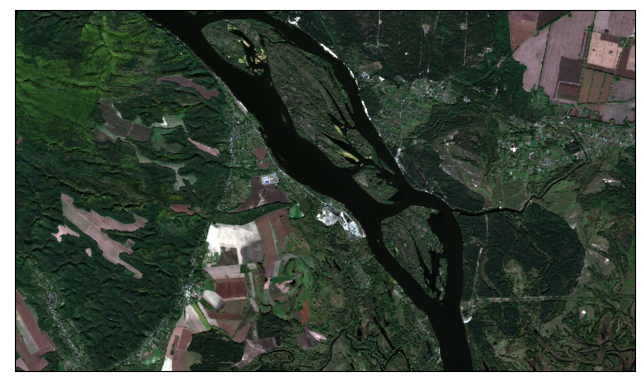

In [491]:
ep.plot_rgb(
    arr_st2,
    rgb=(3, 2, 1),
    stretch=True,
    str_clip=0.2,
    figsize=(8, 10),
    # title="RGB Composite Image with Stretch Applied",
)

plt.show()

In [492]:
tst_img = flattenTestImage(l2)
tst_img_np = np.asarray(tst_img)
tst_img_np.shape
tst_img_np = np.moveaxis(tst_img_np, -1, 0)

In [493]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled2 = scaler.fit_transform(tst_img_np)

In [627]:
test_image_predict_1 = knn_1.predict(X_scaled2)

(638, 1094, 3)


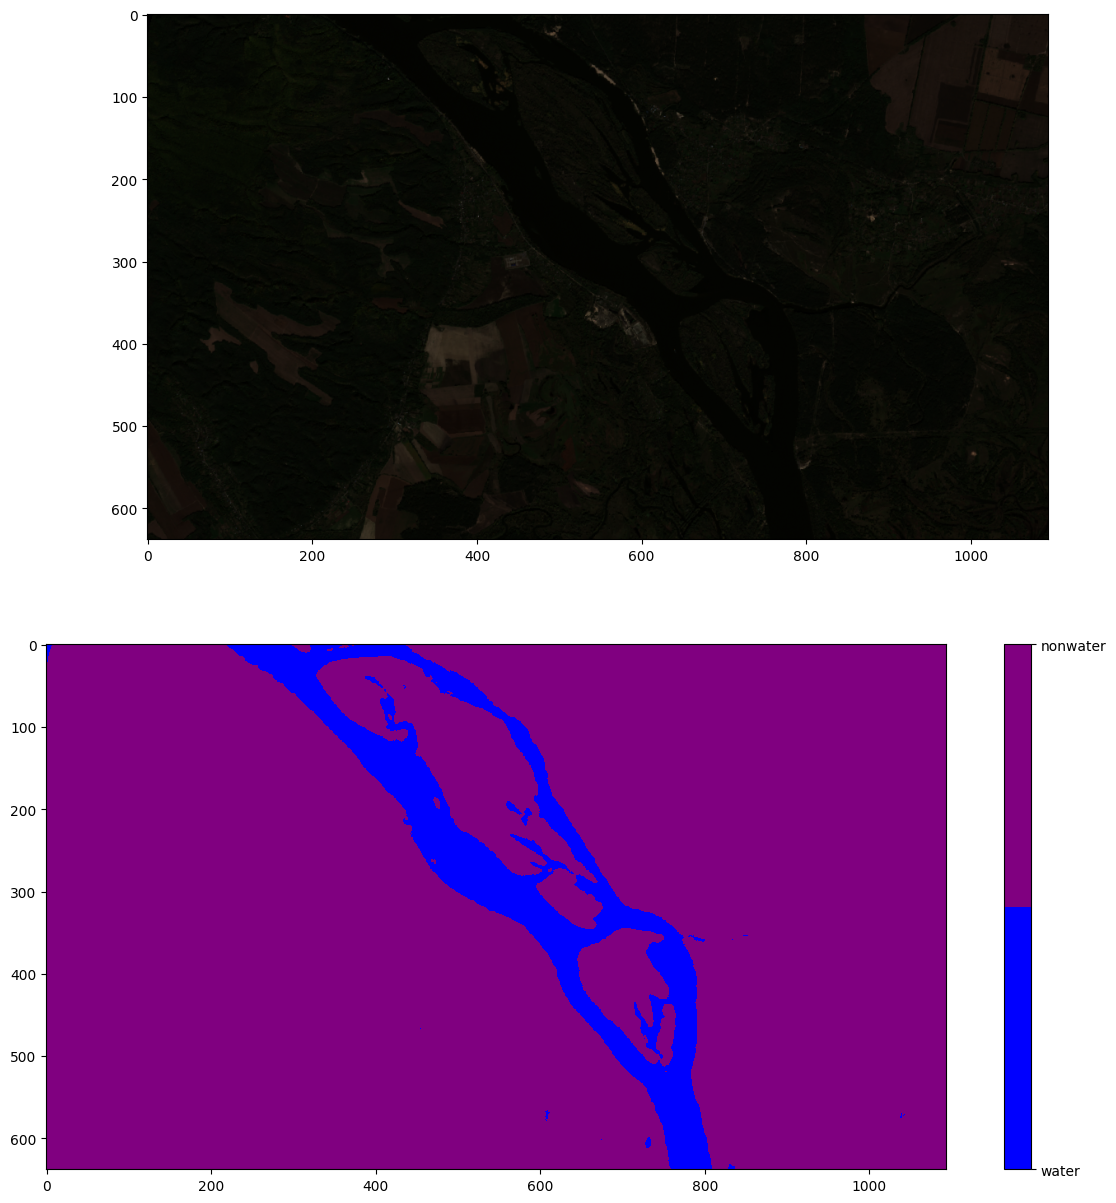

In [628]:
from PIL import Image

mnb_image_default_1 = test_image_predict_1.reshape(arr_st2[0].shape)
# ep.plot_rgb(
#     arr_st2,
#     rgb=(3, 2, 1),
#     # title="RGB Composite Image with Stretch Applied",
# )
# img = np.asarray(Image.open('/tmp/shared/dataset4/27/2022-11-08-00_00_2022-11-08-23_59_Sentinel-2_L2A_Highlight_Optimized_Natural_Color.tiff'))
# plt.imshow(img)
# ep.plot_bands(knn_image_default2, vmin=1,
#               cmap=ListedColormap(['blue', 'yellow', 'purple']))

fig, ax = plt.subplots(2,figsize=(15, 15))

im2_to_show = arr_st2[[3,2,1], :,:]
im2_to_show2 = np.moveaxis(im2_to_show, 0,-1)

print(im2_to_show2.shape)

im2 = ax[0].imshow(im2_to_show2)

im1 = ax[1].imshow(mnb_image_default_1,cmap=ListedColormap(['blue', 'purple']))
labels = list(['water' , 'nonwater'])
values = list([1,2])

# Create a colorbar with the legend
colorbar = fig.colorbar(im1, ticks=values)
colorbar.ax.set_yticklabels(labels)
plt.show()

### Detect forests

In [629]:
y_water_idx = np.where(test_image_predict_1 == 1)[0]

In [630]:
print(f"Water size is {y_water_idx.shape}")

Water size is (58902,)


In [631]:
x_scaled_wo_water = X_scaled2.copy()
y_water = test_image_predict_1[test_image_predict_1 == 1]

In [632]:
print(f"Size before remove water {test_image_predict_1.shape[0]} after {x_scaled_wo_water.shape[0]} and diff {test_image_predict_1.shape[0]-x_scaled_wo_water.shape[0]}")

Size before remove water 697972 after 697972 and diff 0


In [633]:
# for idx in y_water_idx:
#     np.delete(x_scaled_wo_water, idx)
x_scaled_wo_water = np.delete(x_scaled_wo_water, y_water_idx, axis=0)

In [634]:
x_scaled_wo_water.shape

(639070, 12)

In [648]:
test_image_predict_2 = knn_2.predict(x_scaled_wo_water)

In [643]:
#test_image_predict_2 = mnb_2.predict(x_scaled_wo_water)

In [636]:
def split_two_arrays(length, lst):
    l = []
    r = []
    for i in range(length):
        if i in lst:
            l.append(i)
        else:
            r.append(i)

    return (l,r)


In [425]:
idxs_2 = split_two_arrays(x_scaled.shape[0], y_water_idx)

In [426]:
# arr = np.arange(length)
#     mask = np.isin(arr, lst)
#     l = arr[mask]
#     r = arr[~mask]
#     return l, r

In [649]:
test_image_predict_2[test_image_predict_2 == 2] = 3
test_image_predict_2[test_image_predict_2 == 1] = 2

In [650]:
len(test_image_predict_2[test_image_predict_2 == 2])

193316

In [651]:
p = []
iter = 0
w_iter = 0
for i in range(X_scaled2.shape[0]):
    if (i in y_water_idx):
        p.append(y_water[w_iter])
        w_iter+=1
    else:
        p.append(test_image_predict_2[iter])
        iter+=1


In [692]:
knn_compoiste_2 = np.asarray(p)

(638, 1094, 3)


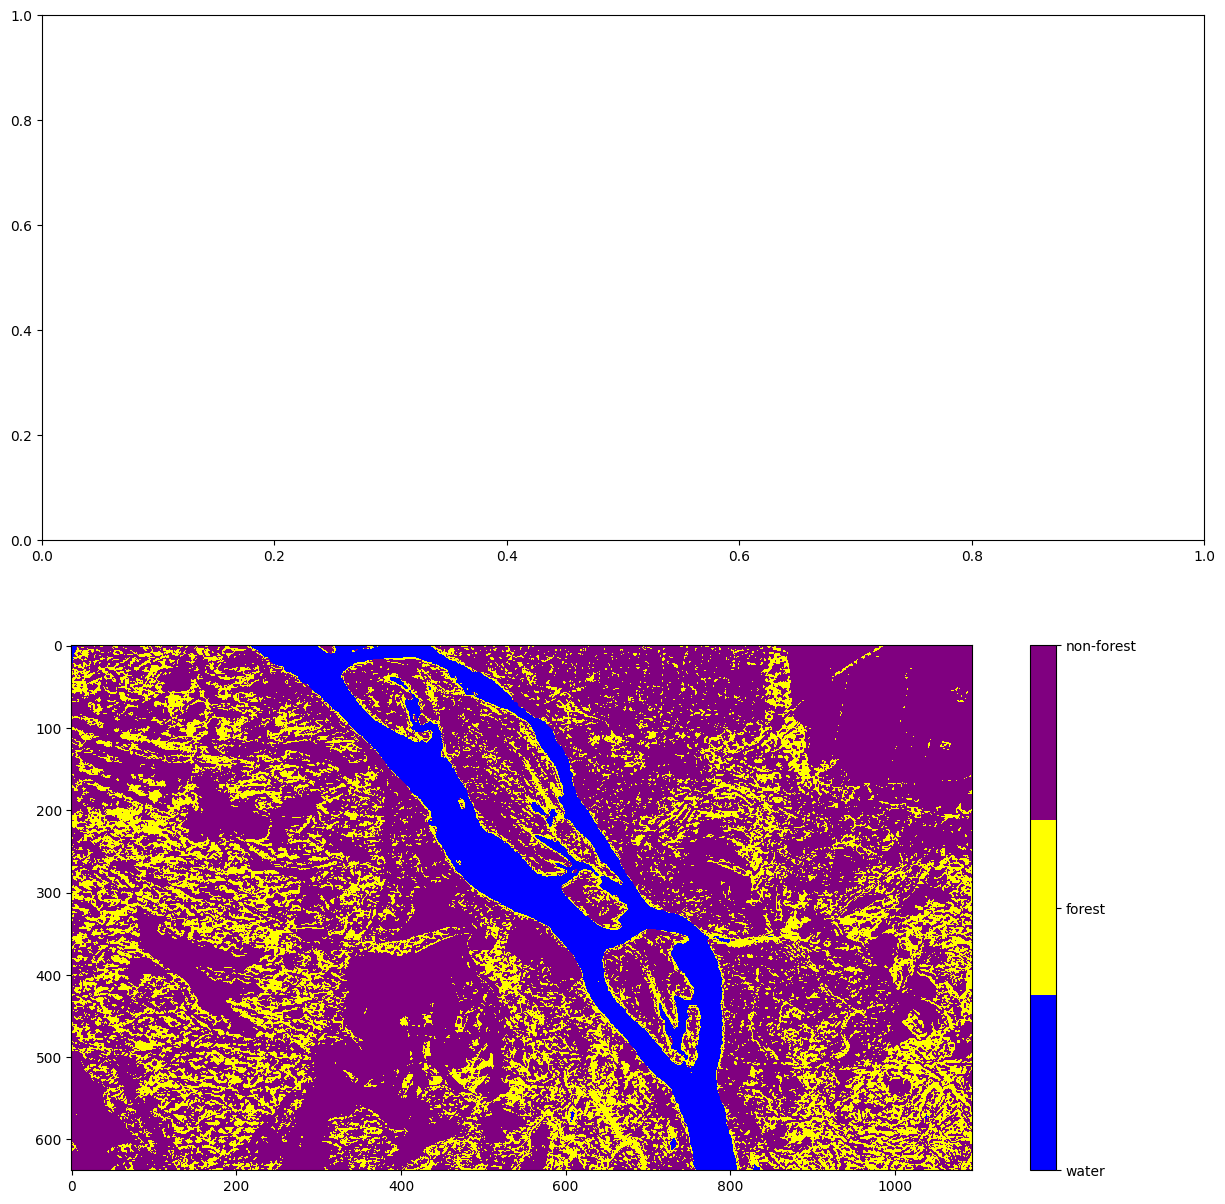

In [652]:
mnb_image_default_2 = np.asarray(p).reshape(arr_st2[0].shape)

fig, ax = plt.subplots(2,figsize=(15, 15))

# im2_to_show = arr_st2[[3,2,1], :,:]
# im2_to_show2 = np.moveaxis(im2_to_show, 0,-1)

print(im2_to_show2.shape)

# im2 = ax[0].imshow(im2_to_show2)

im1 = ax[1].imshow(mnb_image_default_2,cmap=ListedColormap(['blue', 'yellow', 'purple']))
labels = list(['water', 'forest', 'non-forest'])
values = list([1,2,3])

# Create a colorbar with the legend
colorbar = fig.colorbar(im1, ticks=values)
colorbar.ax.set_yticklabels(labels)
plt.show()

### Detect field non-field

In [694]:
y_forest_idx = np.where(knn_compoiste_2 == categories_map["forest"])[0]

In [705]:
y_forest = knn_compoiste_2[knn_compoiste_2 == categories_map["forest"]]

In [698]:
x_predict_3 = X_scaled2.copy()


In [700]:
idx_to_remove = np.concatenate([y_forest_idx, y_water_idx])
x_predict_3 = np.delete(x_predict_3, idx_to_remove, axis=0)
# x_predict_3 = np.delete(x_predict_3, y_water_idx, axis=0)

In [701]:
test_image_predict_3 = knn_3.predict(x_predict_3)

In [703]:
len(test_image_predict_3[test_image_predict_3==2])

141448

In [704]:
test_image_predict_3[test_image_predict_3 == 1] = 3
test_image_predict_3[test_image_predict_3 == 2] = 4

In [707]:
p2 = []
iter = 0
w_iter = 0
f_iter = 0
for i in range(X_scaled2.shape[0]):
    if i in y_water_idx:
        p2.append(y_water[w_iter])
        w_iter+=1
    elif i in y_forest_idx:
        p2.append(y_forest[f_iter])
        f_iter+=1
    else :
        p2.append(test_image_predict_3[iter])
        iter+=1

In [708]:
knn_compoiste_3 = np.asarray(p2)

(638, 1094, 3)


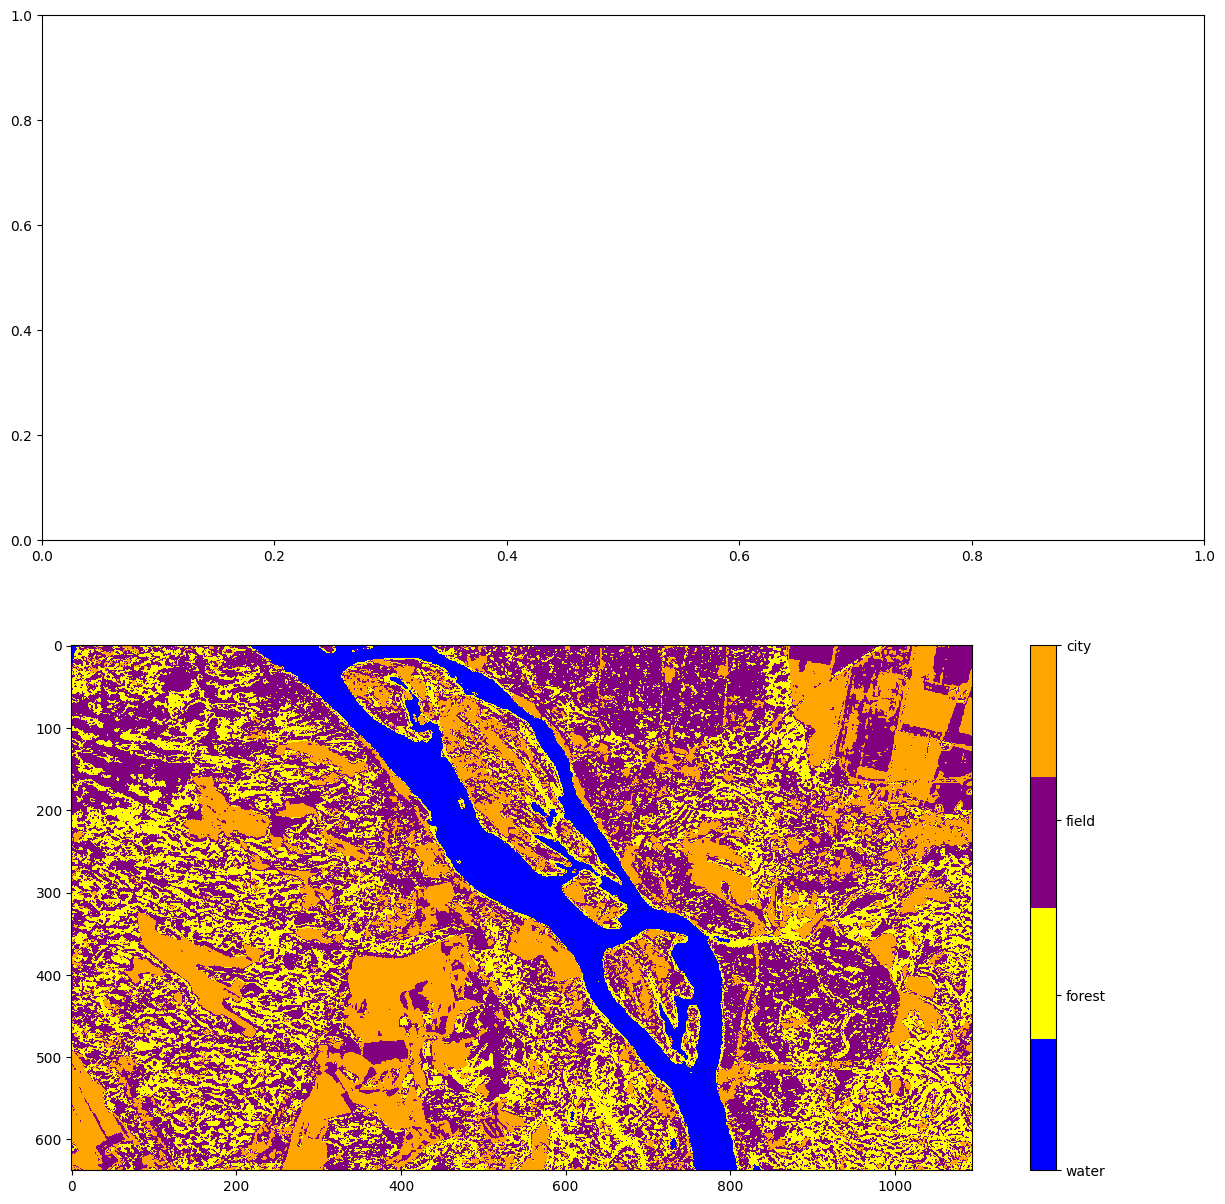

In [710]:
mnb_image_default_2 = knn_compoiste_3.reshape(arr_st2[0].shape)

fig, ax = plt.subplots(2,figsize=(15, 15))

# im2_to_show = arr_st2[[3,2,1], :,:]
# im2_to_show2 = np.moveaxis(im2_to_show, 0,-1)

print(im2_to_show2.shape)

# im2 = ax[0].imshow(im2_to_show2)

im1 = ax[1].imshow(mnb_image_default_2,cmap=ListedColormap(['blue', 'yellow', 'purple', 'orange']))
labels = list(['water', 'forest', 'field', 'city'])
values = list([1,2,3,4])

# Create a colorbar with the legend
colorbar = fig.colorbar(im1, ticks=values)
colorbar.ax.set_yticklabels(labels)
plt.show()

In [711]:
cuml.raft.get_mem_info().total

NameError: name 'cuml' is not defined